# Classes Report

The aim of this notebook is using pattern mining in order to exploit frequent terms and associations to user whenever a twitter were classified as cyberbullying.

## Library & Dataset Import

In [9]:
import pandas as pd
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../dataset/training_set.csv")

df = df[df['multiclass_label'] != 'not_cyberbullying'].copy()


## Dataset Vectorization

In [10]:
#import joblib
tfidf_vectorizer = joblib.load("../model/tfidf_vocabulary_multiclass.pkl")

X_tfidf = tfidf_vectorizer.transform(df['text'])

X_tfidf = (X_tfidf > 0).astype(int)
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df["multiclass_label"] = df["multiclass_label"].values


## Frequent terms & associations mining

/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_7389/4024884056.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_support.values, y=word_support.index, palette="viridis")


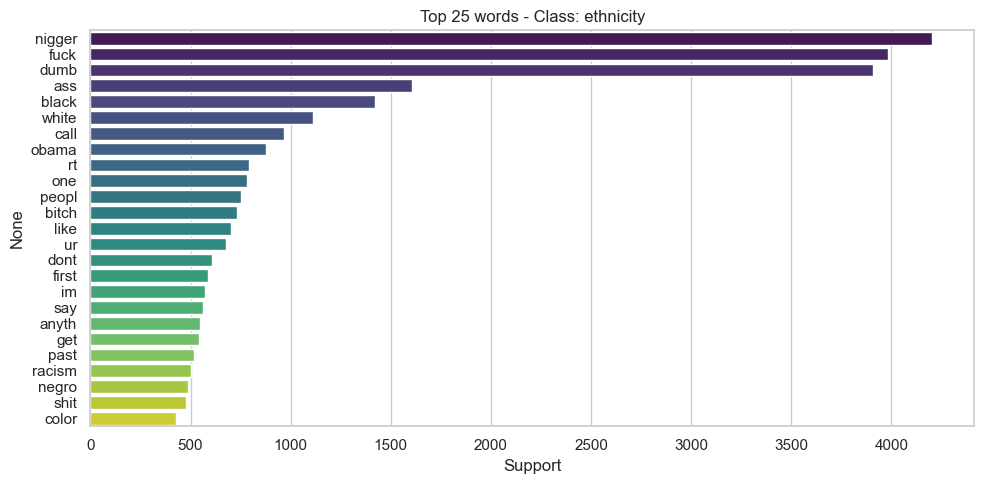

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_7389/4024884056.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_support.values, y=word_support.index, palette="viridis")


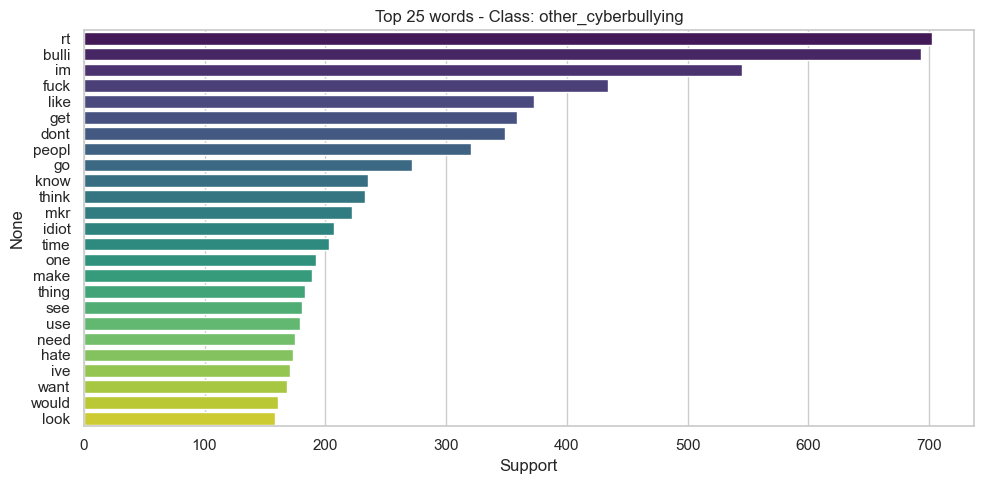

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_7389/4024884056.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_support.values, y=word_support.index, palette="viridis")


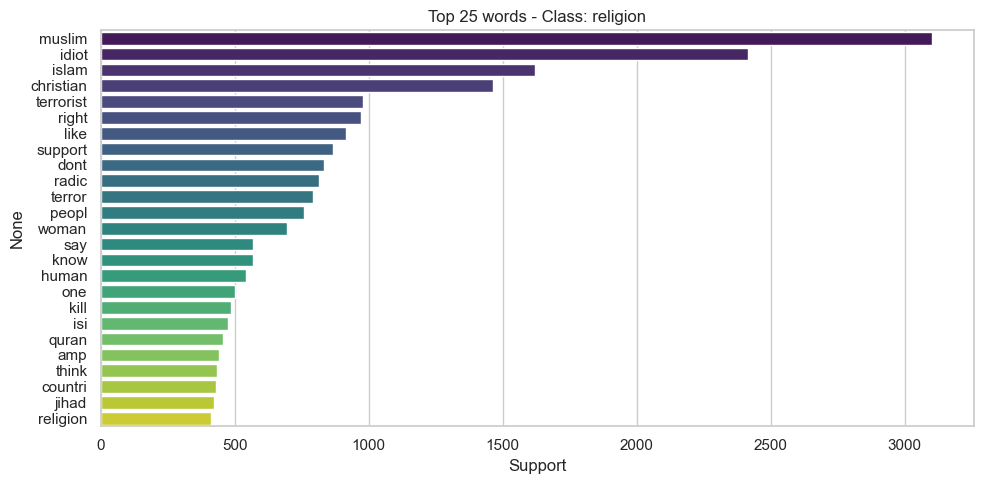

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_7389/4024884056.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_support.values, y=word_support.index, palette="viridis")


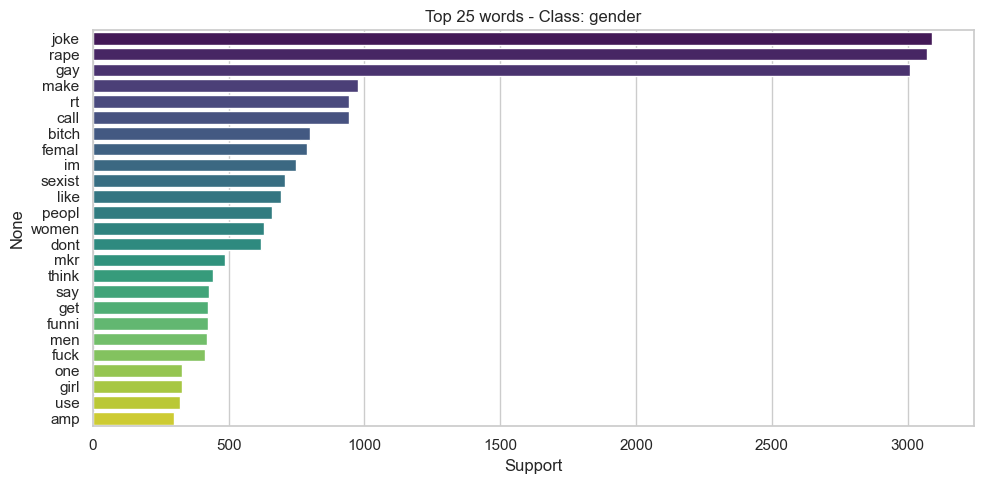

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_7389/4024884056.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=word_support.values, y=word_support.index, palette="viridis")


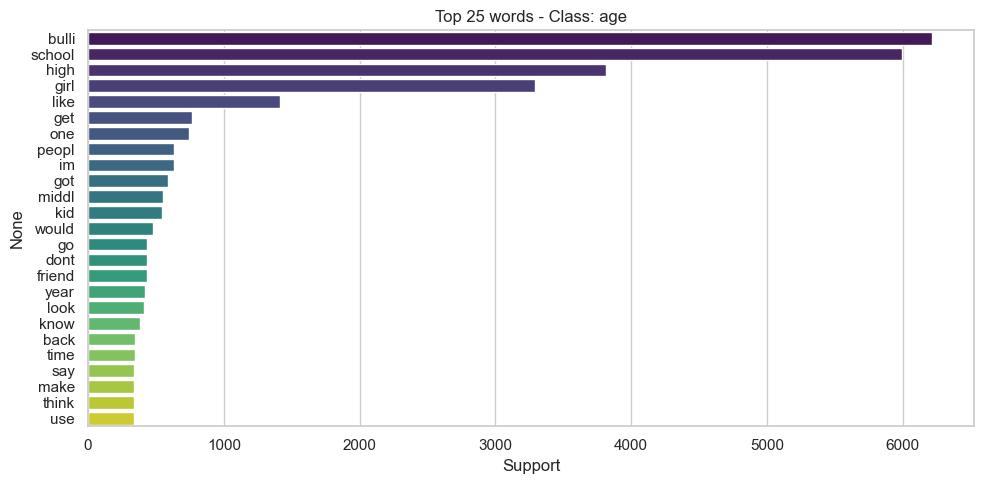

/opt/anaconda3/envs/DMML/lib/python3.11/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [11]:

classi = tfidf_df['multiclass_label'].unique()
rules_by_class = {}


sns.set(style="whitegrid")

for classe in classi:
    class_df = tfidf_df[tfidf_df['multiclass_label'] == classe].drop(columns=['multiclass_label'])

    word_support = class_df.sum().sort_values(ascending=False).head(25)

    plt.figure(figsize=(10, 5))
    sns.barplot(x=word_support.values, y=word_support.index, palette="viridis")
    plt.title(f"Top 25 words - Class: {classe}")
    plt.xlabel("Support")
    plt.tight_layout()

    filename = f"../word_class_distribution/top_25_{classe}.png"
    plt.savefig(filename)
    plt.show()

    frequent_itemsets = apriori(class_df, min_support=0.01, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)
    rules = rules.sort_values(by="lift", ascending=False)

    rules_by_class[classe] = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


In [ ]:
from itertools import combinations

valid_rules = {k: v for k, v in rules_by_class.items() if v is not None and not v.empty}

all_rules = pd.concat(valid_rules, names=["Classe"])
all_rules.reset_index(inplace=True)

all_rules["antecedents_str"] = all_rules["antecedents"].apply(lambda x: sorted(x))
all_rules["consequents_str"] = all_rules["consequents"].apply(lambda x: sorted(x))

all_rules["regola"] = all_rules.apply(
    lambda row: " ".join(sorted(row["antecedents_str"] + row["consequents_str"])),
    axis=1
)

all_rules = all_rules[["Classe", "regola"]]

all_rules.drop_duplicates(inplace=True)

all_rules["regola_set"] = all_rules["regola"].apply(lambda r: set(r.split()))

def filtra_regole_massimali(df_classe):
    idx_to_keep = set(df_classe.index)
    for i, j in combinations(df_classe.index, 2):
        set_i = df_classe.at[i, "regola_set"]
        set_j = df_classe.at[j, "regola_set"]
        if set_i < set_j:
            idx_to_keep.discard(i)  
        elif set_j < set_i:
            idx_to_keep.discard(j)  
    return df_classe.loc[sorted(idx_to_keep)]

all_rules = all_rules.groupby("Classe", group_keys=False).apply(filtra_regole_massimali)

all_rules.drop(columns="regola_set", inplace=True)

print(all_rules["Classe"].value_counts())
all_rules.to_csv("../association_rules/association_rules.csv", index=False)

Classe
age                    327
religion               281
ethnicity              233
gender                 166
other_cyberbullying      5
Name: count, dtype: int64


/var/folders/k5/2x805v8s36zft24jm8_zy2980000gn/T/ipykernel_7389/4039691353.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  all_rules = all_rules.groupby("Classe", group_keys=False).apply(filtra_regole_massimali)
